In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

Applying **Data Augmentation** on the dataset

In [12]:
# Part 1 - Getting the data and defining parameters

from keras.preprocessing.image import ImageDataGenerator
isize = 224

train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/train',
                                                 target_size = (isize, isize),
                                                 class_mode = 'binary',
                                                  classes=['ASD', 'TC']
                                                 )

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/validate',
                                                 target_size = (isize, isize),
                                                 class_mode = 'binary',
                                                   classes=['ASD', 'TC']
                                                 )

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/test',
                                            target_size = (isize, isize),
                                            class_mode = 'binary',
                                            classes=['ASD', 'TC']
                                            )

Found 7176 images belonging to 2 classes.
Found 1460 images belonging to 2 classes.
Found 2450 images belonging to 2 classes.


In [7]:
print(training_set.class_indices)
print(validation_set.class_indices)
print(test_set.class_indices)

{'ASD': 0, 'TC': 1}
{'ASD': 0, 'TC': 1}
{'ASD': 0, 'TC': 1}


# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train

1.   List item
2.   List item

on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [13]:
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(isize, isize,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [17]:
for layer in resnet.layers:
    layer.trainable = False

model = resnet.output
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [19]:
model.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [20]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ABIDE-I dataset/resnet50",monitor="val_accuracy",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_delta = 0.001,verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [21]:
history = model.fit(
    training_set,
    steps_per_epoch=training_set.n // 32,
    validation_data=validation_set,
    validation_steps = validation_set.n // 32,
    epochs=25, verbose=1, batch_size=32,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/25
224/224 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.5063 
Epoch 1: val_accuracy improved from -inf to 0.63125, saving model to /content/drive/MyDrive/ABIDE-I dataset/resnet50
224/224 [==============================] - 6929s 31s/step - loss: 0.8529 - accuracy: 0.5063 - val_loss: 0.6889 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 2/25
224/224 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5126
Epoch 2: val_accuracy did not improve from 0.63125

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
224/224 [==============================] - 33s 145ms/step - loss: 0.6930 - accuracy: 0.5126 - val_loss: 0.6882 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 3/25
224/224 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5119
Epoch 3: val_accuracy did not improve from 0.63125

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
224/224 [==============================] -

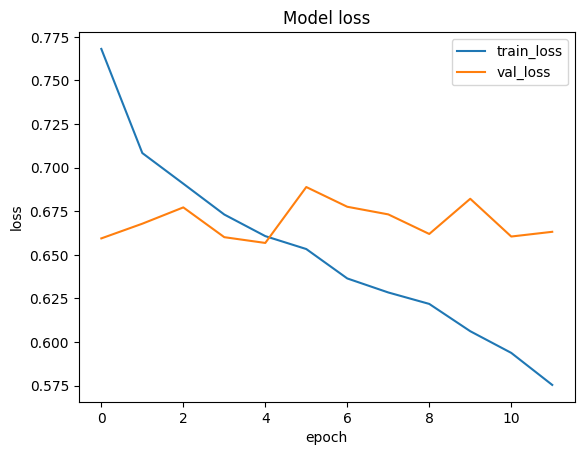

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

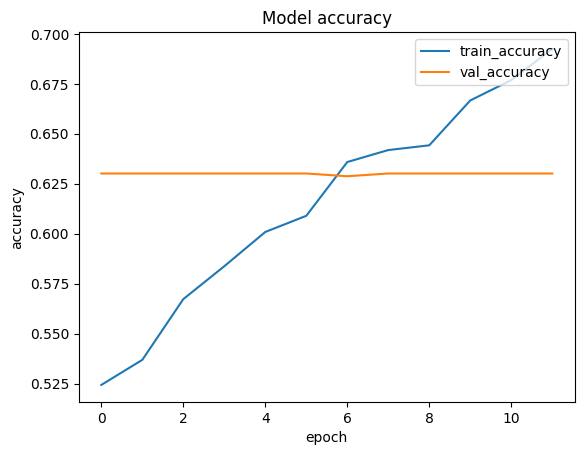

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'upper right')
plt.show()

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

77/77 [==============================] - 6s 78ms/step
Test Accuracy: 45.31%


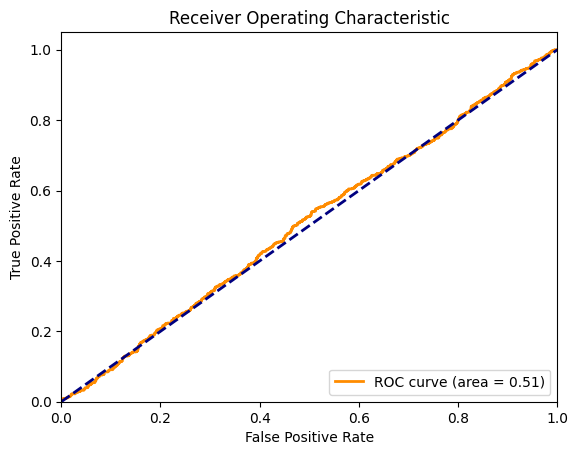

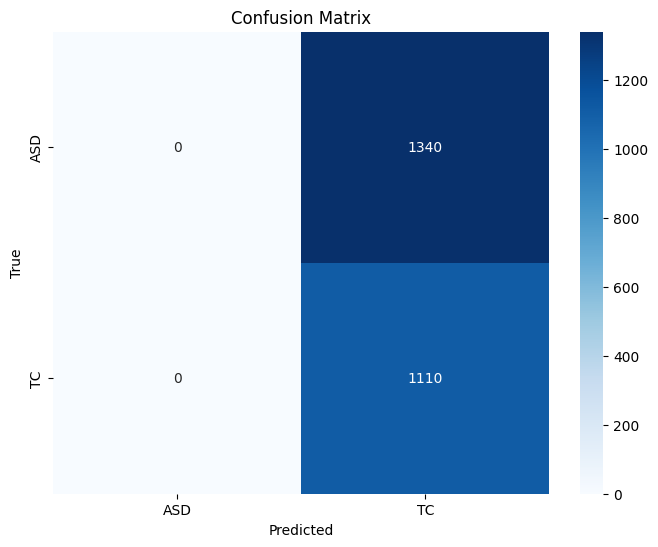

Confusion Matrix:
[[   0 1340]
 [   0 1110]]


In [ ]:
class_names = list(training_set.class_indices.keys())

# Make predictions on the test data
predictions = model.predict(test_set)

# 'predictions' will contain the predicted probabilities for each image
# For binary classification, you can threshold the probabilities to get class predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get the true class labels for the test data
true_classes = test_set.classes

# Calculate test accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Print and return the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print and return the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
model.load_weights("/content/drive/MyDrive/ABIDE-I dataset/effnet.h5")

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

In [ ]:
evaluate

In [ ]:

# Start TensorBoard within the notebook
%tensorboard --logdir=./logs


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1340
           1       0.00      0.00      0.00      1110

    accuracy                           0.55      2450
   macro avg       0.27      0.50      0.35      2450
weighted avg       0.30      0.55      0.39      2450



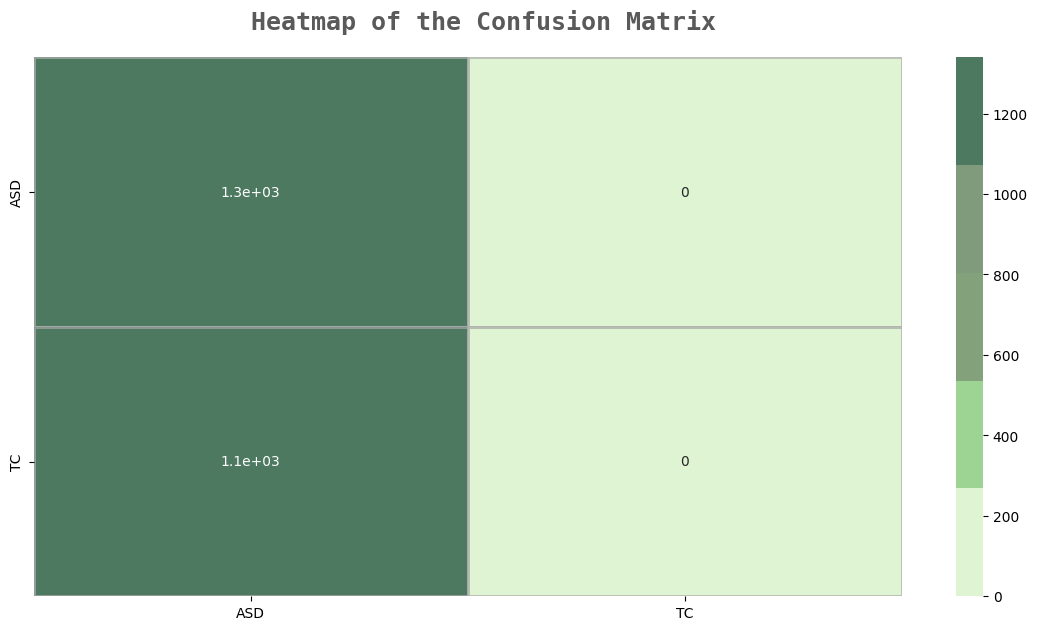

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# <center>Thank You!